<a href="https://colab.research.google.com/github/aiaaee/DigitsRecognition/blob/main/Digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [118]:
from sklearn.datasets import load_digits
import torch
import torchvision.transforms as transforms
from torchvision.transforms import CenterCrop
from torchvision.transforms import Normalize
from torchvision.transforms import v2
import pandas as pd
import numpy as np
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn.feature_extraction.image import grid_to_graph
from scipy import stats
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.semi_supervised import LabelSpreading
from torch.utils.data import Dataset , DataLoader
import torch.nn as nn
from tqdm import tqdm

In [119]:
digits = load_digits()
Display_model = digits
df = pd.DataFrame(data=Display_model.data, columns=Display_model.feature_names)
df.head()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


In [120]:
X , y = digits.data , digits.target

In [121]:
print(X.shape , y.shape)

(1797, 64) (1797,)


In [122]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.2 , random_state=42)

# Standardize

Scaler = StandardScaler()
X_train = Scaler.fit_transform(X_train)

In [123]:
print(X_train.shape , y_train.shape)

(1437, 64) (1437,)


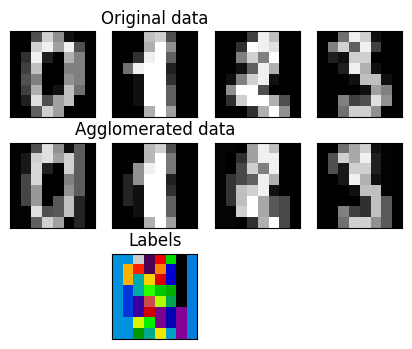

In [124]:
images = digits.images
X = np.reshape(images, (len(images), -1))
connectivity = grid_to_graph(*images[0].shape)

agglo = cluster.FeatureAgglomeration(connectivity=connectivity, n_clusters=32)

agglo.fit(X)
X_reduced = agglo.transform(X)

X_restored = agglo.inverse_transform(X_reduced)
images_restored = np.reshape(X_restored, images.shape)
plt.figure(1, figsize=(4, 3.5))
plt.clf()
plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.91)
for i in range(4):
    plt.subplot(3, 4, i + 1)
    plt.imshow(images[i], cmap=plt.cm.gray, vmax=16, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
    if i == 1:
        plt.title("Original data")
    plt.subplot(3, 4, 4 + i + 1)
    plt.imshow(images_restored[i], cmap=plt.cm.gray, vmax=16, interpolation="nearest")
    if i == 1:
        plt.title("Agglomerated data")
    plt.xticks(())
    plt.yticks(())

plt.subplot(3, 4, 10)
plt.imshow(
    np.reshape(agglo.labels_, images[0].shape),
    interpolation="nearest",
    cmap=plt.cm.nipy_spectral,
)
plt.xticks(())
plt.yticks(())
plt.title("Labels")
plt.show()

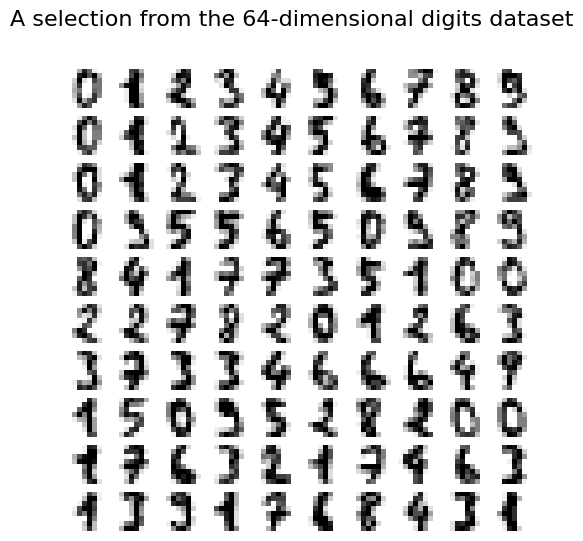

In [125]:
fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(6, 6))
for idx, ax in enumerate(axs.ravel()):
    ax.imshow(X[idx].reshape((8, 8)), cmap=plt.cm.binary)
    ax.axis("off")
_ = fig.suptitle("A selection from the 64-dimensional digits dataset", fontsize=16)

Iteration 0 ______________________________________________________________________
Label Spreading model: 40 labeled & 290 unlabeled (330 total)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       0.78      0.69      0.73        26
           2       0.93      0.93      0.93        29
           3       1.00      0.89      0.94        27
           4       0.92      0.96      0.94        23
           5       0.96      0.70      0.81        33
           6       0.97      0.97      0.97        35
           7       0.94      0.91      0.92        33
           8       0.62      0.89      0.74        28
           9       0.73      0.79      0.76        34

    accuracy                           0.87       290
   macro avg       0.89      0.87      0.87       290
weighted avg       0.88      0.87      0.87       290

Confusion matrix
[[22  0  0  0  0  0  0  0  0  0]
 [ 0 18  2  0  0  0  1  0  5  0]
 [ 0  0 27  0

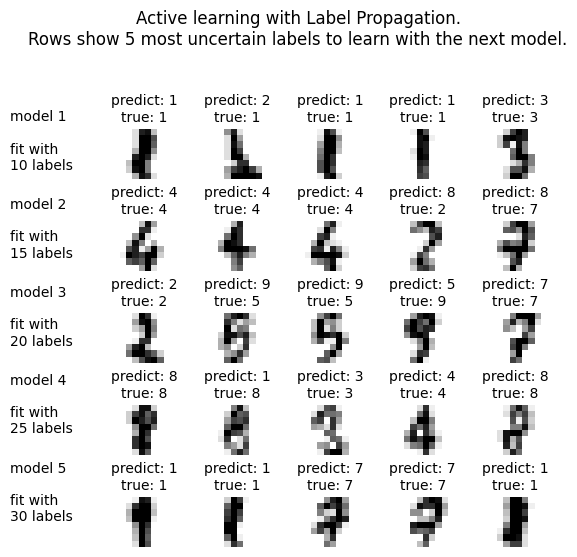

In [126]:
rng = np.random.RandomState(0)
indices = np.arange(len(digits.data))
rng.shuffle(indices)

X = digits.data[indices[:330]]
y = digits.target[indices[:330]]
images = digits.images[indices[:330]]

n_total_samples = len(y)
n_labeled_points = 40
max_iterations = 5

unlabeled_indices = np.arange(n_total_samples)[n_labeled_points:]
f = plt.figure()

for i in range(max_iterations):
    if len(unlabeled_indices) == 0:
        print("No unlabeled items left to label.")
        break
    y_train = np.copy(y)
    y_train[unlabeled_indices] = -1

    lp_model = LabelSpreading(gamma=0.25, max_iter=20)
    lp_model.fit(X, y_train)

    predicted_labels = lp_model.transduction_[unlabeled_indices]
    true_labels = y[unlabeled_indices]

    cm = confusion_matrix(true_labels, predicted_labels, labels=lp_model.classes_)

    print("Iteration %i %s" % (i, 70 * "_"))
    print(
        "Label Spreading model: %d labeled & %d unlabeled (%d total)"
        % (n_labeled_points, n_total_samples - n_labeled_points, n_total_samples)
    )

    print(classification_report(true_labels, predicted_labels))

    print("Confusion matrix")
    print(cm)

    # compute the entropies of transduced label distributions
    pred_entropies = stats.distributions.entropy(lp_model.label_distributions_.T)

    # select up to 5 digit examples that the classifier is most uncertain about
    uncertainty_index = np.argsort(pred_entropies)[::-1]
    uncertainty_index = uncertainty_index[
        np.isin(uncertainty_index, unlabeled_indices)
    ][:5]

    # keep track of indices that we get labels for
    delete_indices = np.array([], dtype=int)

    # for more than 5 iterations, visualize the gain only on the first 5
    if i < 5:
        f.text(
            0.05,
            (1 - (i + 1) * 0.183),
            "model %d\n\nfit with\n%d labels" % ((i + 1), i * 5 + 10),
            size=10,
        )
    for index, image_index in enumerate(uncertainty_index):
        image = images[image_index]

        # for more than 5 iterations, visualize the gain only on the first 5
        if i < 5:
            sub = f.add_subplot(5, 5, index + 1 + (5 * i))
            sub.imshow(image, cmap=plt.cm.gray_r, interpolation="none")
            sub.set_title(
                "predict: %i\ntrue: %i"
                % (lp_model.transduction_[image_index], y[image_index]),
                size=10,
            )
            sub.axis("off")

        # labeling 5 points, remote from labeled set
        (delete_index,) = np.where(unlabeled_indices == image_index)
        delete_indices = np.concatenate((delete_indices, delete_index))

    unlabeled_indices = np.delete(unlabeled_indices, delete_indices)
    n_labeled_points += len(uncertainty_index)

f.suptitle(
    (
        "Active learning with Label Propagation.\nRows show 5 most "
        "uncertain labels to learn with the next model."
    ),
    y=1.15,
)
plt.subplots_adjust(left=0.2, bottom=0.03, right=0.9, top=0.9, wspace=0.2, hspace=0.85)
plt.show()


In [151]:
transforms = torch.nn.Sequential(
    CenterCrop(10),
    Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
)
FeatureTransforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale=True),
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class DigitsDataSet(Dataset):
  def __init__(self , target , feature , transform=None , target_transform=None):
    self.feature = feature
    self.target = target
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self ):
    return len(self.feature)

  def __getitem__(self , index):
    x = self.feature[index]
    y = self.target[index]
    if self.transform :
      x = self.transform(x)
    if self.target_transform :
      y = self.target_transform(y)
    return x , y

In [152]:
DigitsDataSet

__main__.DigitsDataSet

In [169]:
Train_dataset = DigitsDataSet(X_train , y_train , transform=None , target_transform=None)
Test_dataset = DigitsDataSet(X_test , y_test)


Train_DataLoader = DataLoader(Train_dataset , batch_size=32 , shuffle=True)
Test_DataLoader = DataLoader(Test_dataset , batch_size=32 , shuffle=False)

In [170]:
for i , y in Train_DataLoader:
  print(i.size())
  break

torch.Size([32])


In [162]:
class NeuralNet(nn.Module):
  def __init__(self , in_feature , hidden_feature , out_feature  , *args , **kwargs):
    super().__init__(*args , **kwargs)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(in_features=in_feature , out_features=hidden_feature)
    self.fc2 = nn.Linear(hidden_feature , hidden_feature)
    self.fc3 = nn.Linear(hidden_feature , out_features=out_feature)
  def forward(self , x ):
    output = self.flatten(x)
    output = nn.ReLU(self.fc1(output))
    output = nn.ReLU(self.fc2(output))
    output = nn.ReLU(self.fc3(output))
    return output

In [163]:
model = NeuralNet(64 , 200 , 10)
model

NeuralNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=64, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=10, bias=True)
)

In [164]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters() , lr=1e-3)

In [165]:
train_history = []
validation_history = []
num_epochs = 30
for epoch in range(num_epochs):

    model.train()
    losses = []

    with tqdm(Train_DataLoader, leave=False) as bar:
        bar.set_description(f"[Epoch: {epoch + 1}/{num_epochs}]")

        for batch_idx, (data, target) in enumerate(bar):

            output = model(data)

            loss = criterion(output, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            bar.set_postfix(avg_epoch_loss=f"{sum(losses)/len(losses):.4f}")
    train_history.append(sum(losses)/len(losses))

    model.eval()
    running_testloss = 0.0

    with torch.no_grad():
        for i, (test_data, test_label) in enumerate(test_loader):
            test_output = model(test_data)
            vloss = criterion(test_output, test_label)
            running_testloss += vloss.item()
        avg_vloss = running_testloss / (i + 1)
        validation_history.append(avg_vloss)
        if epoch % 10 == 9:
            print(f'Epoch [{epoch + 1}/{num_epochs}]: loss train: {sum(losses)/len(losses):.3f}, validation: {avg_vloss:.3f}')

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)